# Integrated Gradients

**idea:** Helps to understand why a model made a specific decision. For example, it predicted a number "3" in an image. You want to know which pixels were most responsible for that decision. Answering the question "What parts of the input were most important in getting from a baseline (like a blank image) to the actual prediction?"

Baseline input: A neutral version of your input (e.g., a black image with all zeros).
Actual input: The real input (e.g., the handwritten digit image).
Gradient: It shows how much a change in input affects the model’s prediction.
Integrated gradient: You average gradients from baseline to input across many small steps.

Process: 
- Slowly fade in the image from black to full image.
- At each step, see how the model's prediction changes.
- Average these changes to find out which pixels mattered most.

In [3]:
!pip install captum

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 71.3 MB/s  0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Define a simple neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [6]:
# Load MNIST data
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [7]:
# Load MNIST data
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [8]:
# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Train the model (quick 1-epoch training for demo)
for epoch in range(1):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

In [11]:
# Select a test image
model.eval()
images, labels = next(iter(test_loader))
image = images[0].to(device)
label = labels[0].item()

In [12]:
# Use Integrated Gradients
ig = IntegratedGradients(model)

In [13]:
# Set baseline to a black image (all zeros)
baseline = torch.zeros_like(image)

In [14]:
# Get attribution scores
attributions, delta = ig.attribute(inputs=image.unsqueeze(0), 
                                   baselines=baseline.unsqueeze(0), 
                                   target=label, 
                                   return_convergence_delta=True)

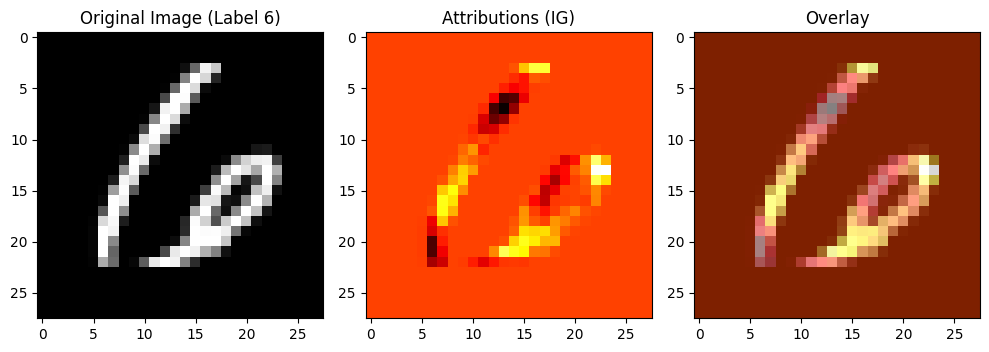

In [15]:
# Visualize the attribution
attributions = attributions.squeeze().cpu().detach().numpy()
image_np = image.squeeze().cpu().detach().numpy()

plt.figure(figsize=(10,4))

plt.subplot(1, 3, 1)
plt.imshow(image_np, cmap='gray')
plt.title(f"Original Image (Label {label})")

plt.subplot(1, 3, 2)
plt.imshow(attributions, cmap='hot')
plt.title("Attributions (IG)")

plt.subplot(1, 3, 3)
plt.imshow(image_np, cmap='gray')
plt.imshow(attributions, cmap='hot', alpha=0.5)
plt.title("Overlay")

plt.tight_layout()
plt.show()